In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file("D:/sky.jpg", "https://i.imgur.com/aGBdQyK.jpg")
result_prefix = "sky_dream"

# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
layer_settings = {
    "mixed4": 0.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 0.5,
}

# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 10  # Number of ascent steps per scale
max_loss = 15.0


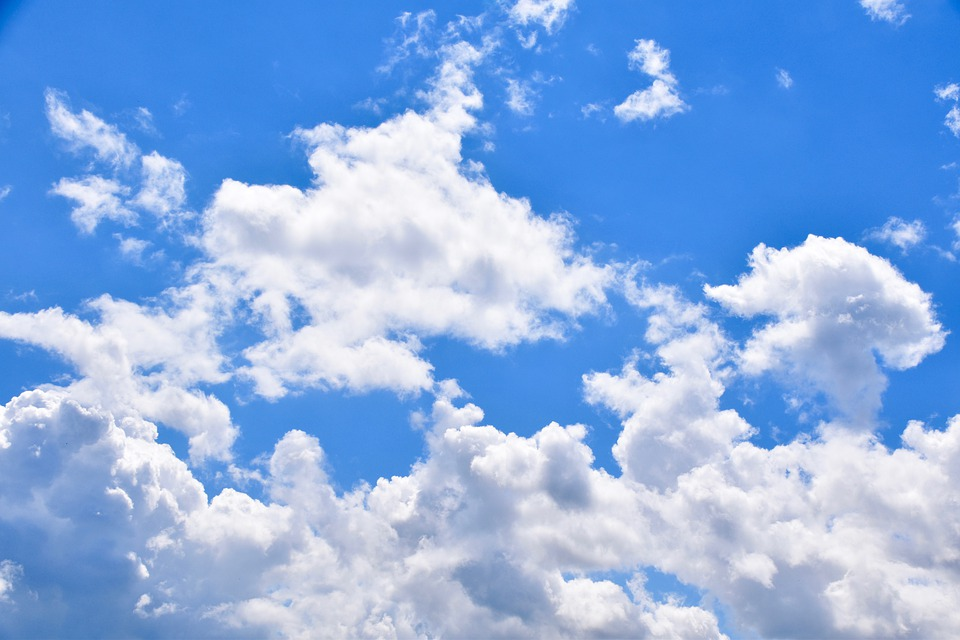

In [2]:
from IPython.display import Image, display

display(Image(base_image_path))


In [3]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate arrays.
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a NumPy array into a valid image.
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Undo inception v3 preprocessing
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



In [8]:
import matplotlib.pyplot as plt

In [9]:
proc = preprocess_image("sky.jpg")
plt.imshow(proc[0])

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [ ]:
deproc = deprocess_image(proc)
plt.imshow(deproc)

In [11]:
# Build an InceptionV3 model loaded with pre-trained ImageNet weights
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

# Set up a model that returns the activation values for every target layer
# (as a dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


In [12]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Initialize the loss
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # We avoid border artifacts by only involving non-border pixels in the loss.
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        print(scaling)
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss



In [13]:

@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img



In [14]:
%%time
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    print(shape)
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  # Make a copy
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))


(457, 685)
(326, 489)
Processing octave 0 with shape (326, 489)
Tensor("Prod:0", shape=(), dtype=float32)
Tensor("Prod_1:0", shape=(), dtype=float32)
Tensor("Prod_2:0", shape=(), dtype=float32)
Tensor("Prod_3:0", shape=(), dtype=float32)
... Loss value at step 0: 0.28
... Loss value at step 1: 0.42
... Loss value at step 2: 0.62
... Loss value at step 3: 0.87
... Loss value at step 4: 1.09
... Loss value at step 5: 1.31
... Loss value at step 6: 1.51
... Loss value at step 7: 1.71
... Loss value at step 8: 1.89
... Loss value at step 9: 2.02
Processing octave 1 with shape (457, 685)
Tensor("Prod:0", shape=(), dtype=float32)
Tensor("Prod_1:0", shape=(), dtype=float32)
Tensor("Prod_2:0", shape=(), dtype=float32)
Tensor("Prod_3:0", shape=(), dtype=float32)
... Loss value at step 0: 0.62
... Loss value at step 1: 1.02
... Loss value at step 2: 1.34
... Loss value at step 3: 1.60
... Loss value at step 4: 1.82
... Loss value at step 5: 2.06
... Loss value at step 6: 2.27
... Loss value at s

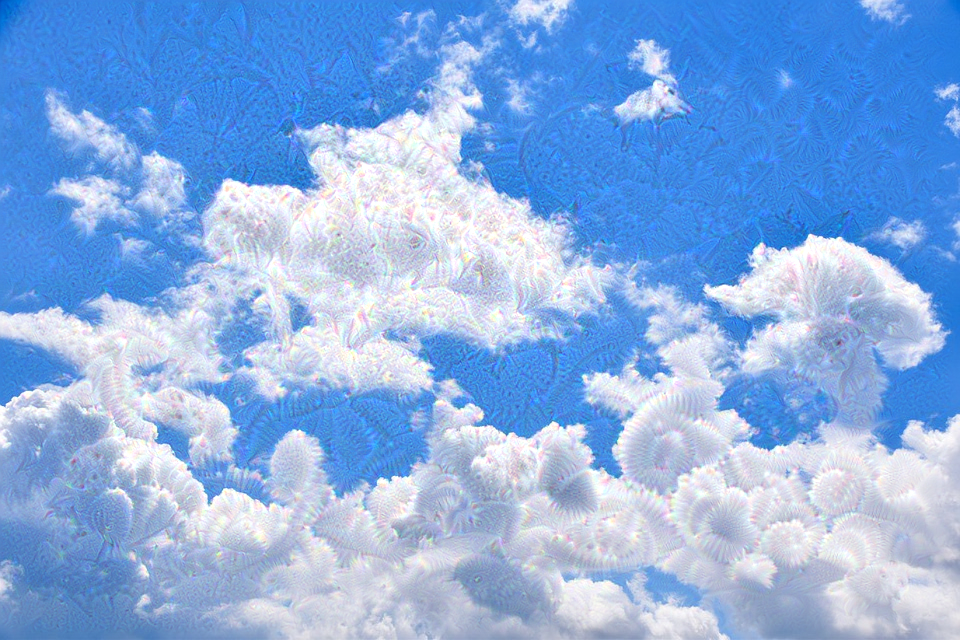

In [15]:
display(Image(result_prefix + ".png"))
